In [1]:
import os
import shutil
import tempfile
import time
import matplotlib.pyplot as plt
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader, decollate_batch
from monai.handlers.utils import from_engine
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.networks.nets import SegResNet
from monai.transforms import (
    Activations,
    Activationsd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    Invertd,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    EnsureTyped,
    EnsureChannelFirstd,
    SpatialPadd,
    SpatialCropd,
    ScaleIntensityd,
    ShiftIntensityd,
    ResizeD,
    AdjustContrastd
)
from monai.utils import set_determinism
import numpy as np
import torch
from torch.utils.data import SubsetRandomSampler

import torch
import torch.nn as nn
import torch.nn.functional as F
from monai.networks.nets import SegResNet
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.transforms import Activations, AsDiscrete
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset
from monai.utils import set_determinism
print_config()

MONAI version: 1.1.0
Numpy version: 1.23.5
Pytorch version: 2.0.1+cu117
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: a2ec3752f54bfc3b40e7952234fbeb5452ed63e3
MONAI __file__: /usr/local/lib/python3.8/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.12
Nibabel version: 5.1.0
scikit-image version: 0.20.0
Pillow version: 9.5.0
Tensorboard version: 2.12.3
gdown version: 4.7.1
TorchVision version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.65.0
lmdb version: 1.4.1
psutil version: 5.9.5
pandas version: 2.0.1
einops version: 0.6.1
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: 2.3.2
pynrrd version: 1.0.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [2]:
data_dir =  "/home/Task07_Pancreas/"
images_dir = os.path.join(data_dir, "imagesTr")
labels_dir = os.path.join(data_dir, "labelsTr")

In [3]:

image_paths = [os.path.join(images_dir, file) for file in os.listdir(images_dir) if not file.endswith('.DS_Store')]

label_paths = [os.path.join(labels_dir, file) for file in os.listdir(labels_dir) if not file.endswith('.DS_Store')]


In [5]:

import os
import nibabel as nib
import numpy as np
import torch
from monai.transforms import Transform, Compose, LoadImaged, EnsureChannelFirstd, EnsureTyped, NormalizeIntensityd, ResizeD

# Determine the maximum number of channels across all images and labels
max_channels_image = 0
max_channels_label = 0
for image_path, label_path in zip(image_paths, label_paths):
    image = nib.load(image_path).get_fdata()
    label = nib.load(label_path).get_fdata()
    max_channels_image = max(max_channels_image, image.shape[-1])
    max_channels_label = max(max_channels_label, label.shape[-1])
    break

print(f"Max channels in images: {max_channels_image}")
print(f"Max channels in labels: {max_channels_label}")



Max channels in images: 79
Max channels in labels: 79


In [7]:
class CombineChannels(Transform):
    def __init__(self, keys):
        self.keys = keys

    def __call__(self, data):
        for key in self.keys:
            # Average the channels
            data[key] = np.mean(data[key], axis=0)[np.newaxis, :, :]
        
        return data


In [8]:
device = torch.device("cuda:0")

In [9]:
class ConvertToMultiClassLabel(Transform):
    def __call__(self, data):
        label = data["label"]
        # Single-channel label, convert to three-channel
        multiclass_label = torch.zeros(3, *label.shape[1:], dtype=torch.float32)
        multiclass_label[0] = (label[0] == 0).float()  # category 0
        multiclass_label[1] = (label[0] == 1).float()  # category 1
        multiclass_label[2] = (label[0] == 2).float()  # category 2

        data["label"] = multiclass_label
        return data

train_transform = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    # CombineChannels(keys=["image"]),  # Apply CombineChannels only on image
    ConvertToMultiClassLabel(),  # Convert label to multi-class format with three channels
    EnsureTyped(keys=["image", "label"]),
    # NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    ScaleIntensityd(keys="image", minv=0.1, maxv=30),  # Adjust intensity values between 0.5 and 1.5
    AdjustContrastd(keys="image", gamma=1.2),  # Increase contrast by applying gamma correction
    ResizeD(keys=["image", "label"], spatial_size=[224, 224, 144], mode=("trilinear", "nearest")),
])

val_transform = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    # CombineChannels(keys=["image"]),  # Apply CombineChannels only on image
    ConvertToMultiClassLabel(),  # Convert label to multi-class format with three channels
    EnsureTyped(keys=["image", "label"]),
    # NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    ScaleIntensityd(keys="image", minv=0.1, maxv=30),  # Adjust intensity values between 0.5 and 1.5
    AdjustContrastd(keys="image", gamma=1.2),  # Increase contrast by applying gamma correction
    ResizeD(keys=["image", "label"], spatial_size=[224, 224, 144], mode=("trilinear", "nearest")),
])


In [10]:
#add random transformations
#dice score - exclude - bg
#cache datset
#UNET

In [11]:
root_dir =  "/home/"
# Set the number of images to use
num_train_images = 225
num_val_images = 55
# here we don't cache any data in case out of memory issue
train_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task07_Pancreas",
    transform=train_transform,
    section="training",
    download=False,
    cache_rate=0.0,
    num_workers=4,
)
train_indices = torch.randperm(len(train_ds))[:num_train_images]
train_sampler = SubsetRandomSampler(train_indices)
train_loader = DataLoader(train_ds, batch_size=1, sampler=train_sampler, num_workers=4)

val_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task07_Pancreas",
    transform=val_transform,
    section="validation",
    download=False,
    cache_rate=0.0,
    num_workers=4,
)
val_indices = torch.randperm(len(val_ds))[:num_val_images]
val_sampler = SubsetRandomSampler(val_indices)
val_loader = DataLoader(val_ds, batch_size=1, sampler=val_sampler, num_workers=4)

In [12]:
# import matplotlib.pyplot as plt

# for i in range(5):
#     val_data_example = val_ds[i]
#     image = val_data_example["image"][0, :, :, 60].detach().cpu()
#     label = val_data_example["label"][:, :, :, 60].detach().cpu()

#     fig, axs = plt.subplots(1, 4, figsize=(20, 5))

#     # Plot the input image
#     axs[0].imshow(image, cmap="gray")
#     axs[0].set_title("Input Image")
#     axs[0].axis("off")

#     # Plot each channel of the label stacked on top of the input image
#     for j in range(3):
#         axs[j + 1].imshow(label[j], cmap="jet", alpha=0.5)
#         axs[j + 1].set_title(f"Label Channel {j + 1}")
#         axs[j + 1].axis("off")

#     plt.tight_layout()
#     plt.show()


image shape: torch.Size([1, 224, 224, 144])
label shape: torch.Size([3, 224, 224, 144])


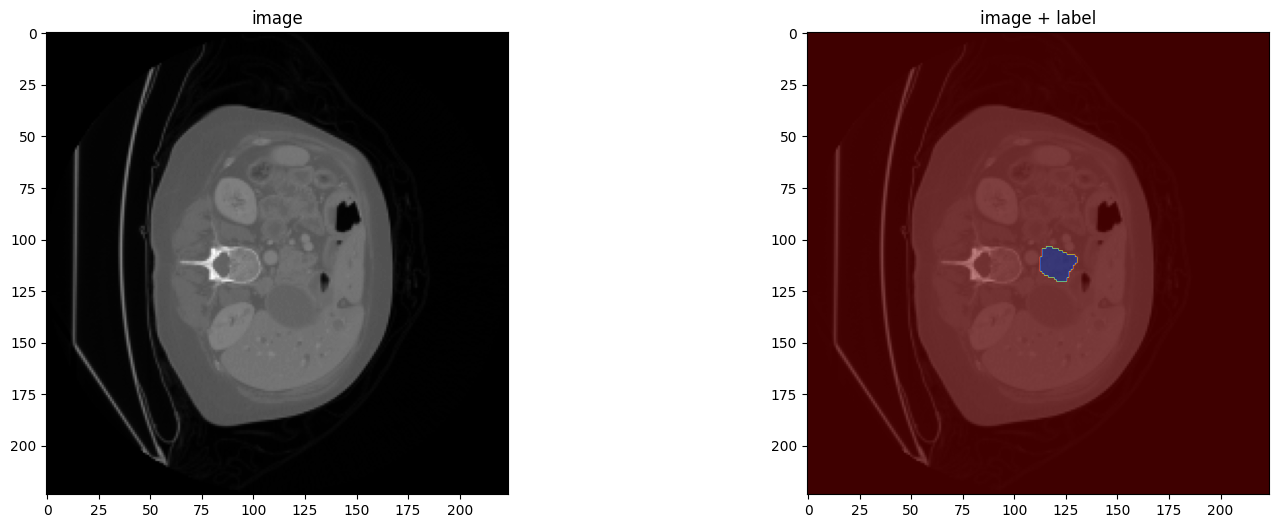

image shape: torch.Size([1, 224, 224, 144])
label shape: torch.Size([3, 224, 224, 144])


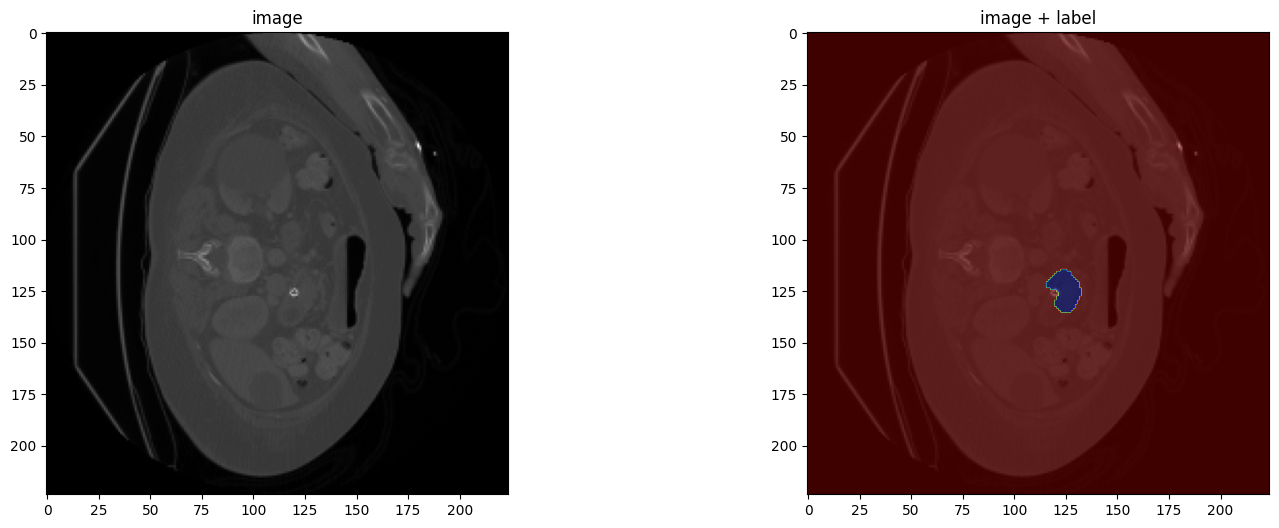

image shape: torch.Size([1, 224, 224, 144])
label shape: torch.Size([3, 224, 224, 144])


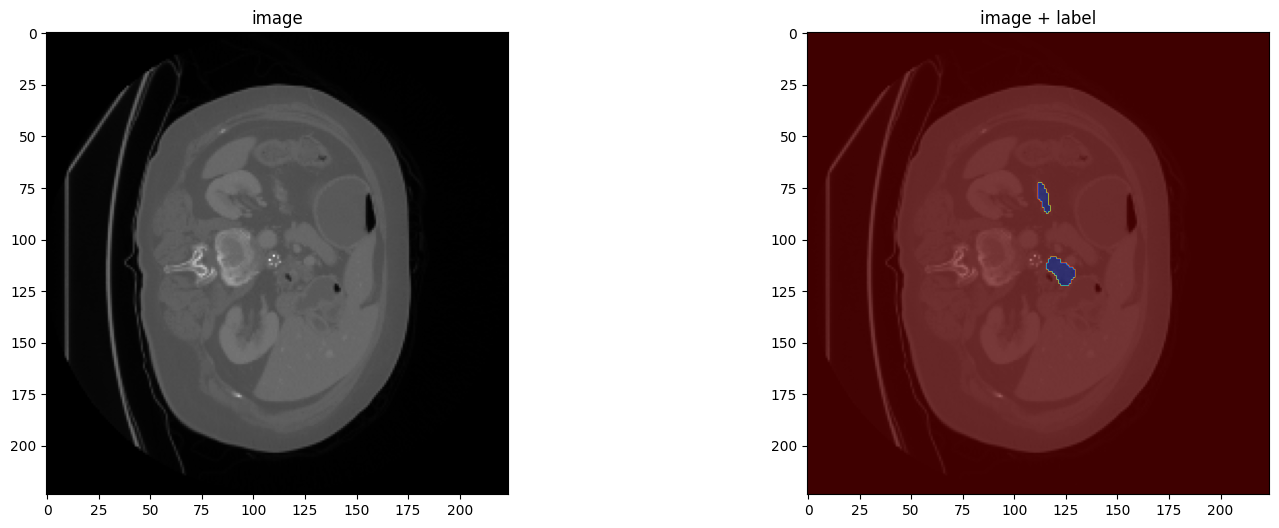

image shape: torch.Size([1, 224, 224, 144])
label shape: torch.Size([3, 224, 224, 144])


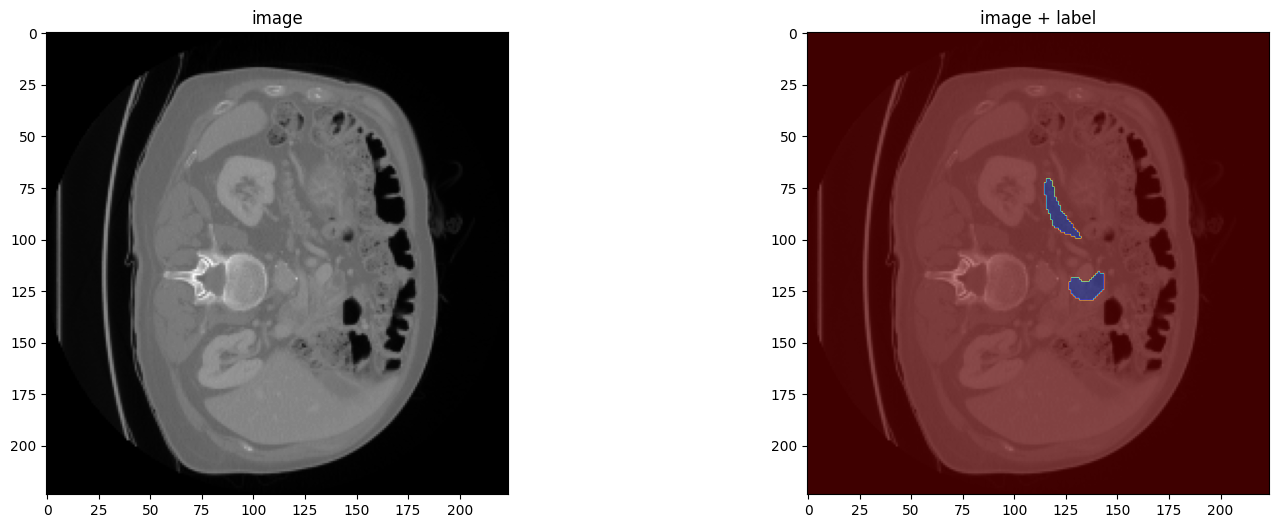

image shape: torch.Size([1, 224, 224, 144])
label shape: torch.Size([3, 224, 224, 144])


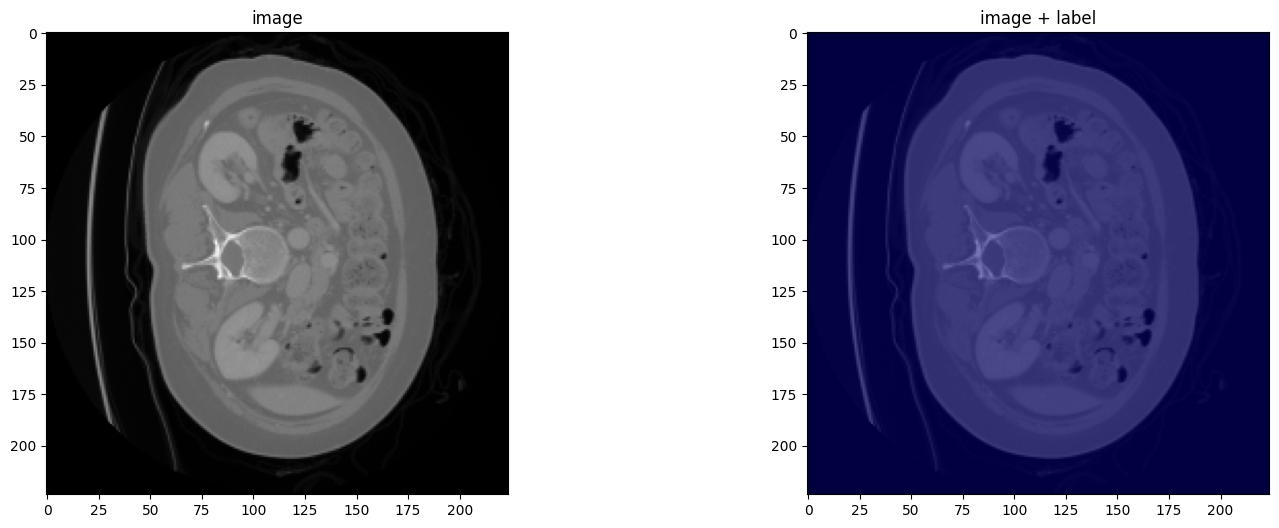

In [10]:
import matplotlib.pyplot as plt
for i in range(0,5):
    val_data_example = val_ds[i]
    print(f"image shape: {val_data_example['image'].shape}")
    plt.figure("image and label", (18, 6))

    # Plot the image
    plt.subplot(1, 2, 1)
    plt.title("image")
    plt.imshow(val_data_example["image"][0, :, :, 60].detach().cpu(), cmap="gray")

    # Plot the label with transparency
    label_image = val_data_example["label"][0, :, :, 60].detach().cpu()
    plt.subplot(1, 2, 2)
    plt.title("image + label")
    print(f"label shape: {val_data_example['label'].shape}")
    plt.imshow(val_data_example["image"][0, :, :, 60].detach().cpu(), cmap="gray")
    plt.imshow(label_image, cmap="jet", alpha=0.5)

    plt.show()


In [13]:

# Define your UNet model as a function
def unet(in_channels, out_channels):
    model = SegResNet(
        blocks_down=[1, 2, 2, 4],
        blocks_up=[1, 1, 1],
        init_filters=16,
        in_channels=in_channels,
        out_channels=out_channels,
        dropout_prob=0.2,
    )
    return model


In [14]:

# Define your UNet model
in_channels = 1
out_channels = 3
model = unet(in_channels, out_channels)

# Rest of the code
max_epochs = 30
val_interval = 1
VAL_AMP = True

device = torch.device("cuda:0")
model = model.to(device)
loss_function = DiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, to_onehot_y=False, sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4, weight_decay=1e-5)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

dice_metric = DiceMetric(include_background=True, reduction="mean")
dice_metric_batch = DiceMetric(include_background=True, reduction="mean_batch")

post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])


def inference(input):
    def _compute(input):
        return sliding_window_inference(
            inputs=input,
            roi_size=(240, 240, 160),
            sw_batch_size=1,
            predictor=model,
            overlap=0.5,
        )

    if VAL_AMP:
        with torch.cuda.amp.autocast():
            return _compute(input)
    else:
        return _compute(input)


scaler = torch.cuda.amp.GradScaler()
torch.backends.cudnn.benchmark = True


In [15]:
best_metric = -1
best_metric_epoch = -1
best_metrics_epochs_and_time = [[], [], []]
epoch_loss_values = []
metric_values = []
metric_values_tc = []
metric_values_wt = []
metric_values_et = []
max_epochs=30

total_start = time.time()
for epoch in range(max_epochs):
    epoch_start = time.time()
    print('hello')
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step_start = time.time()
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}"
            f", train_loss: {loss.item():.4f}"
            f", step time: {(time.time() - step_start):.4f}"
        )
    lr_scheduler.step()
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                val_outputs = inference(val_inputs)
                val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                dice_metric(y_pred=val_outputs, y=val_labels)
                dice_metric_batch(y_pred=val_outputs, y=val_labels)

            metric = dice_metric.aggregate().item()
            metric_values.append(metric)
            metric_batch = dice_metric_batch.aggregate()
            metric_tc = metric_batch[0].item()
            metric_values_tc.append(metric_tc)
            metric_wt = metric_batch[1].item()
            metric_values_wt.append(metric_wt)
            metric_et = metric_batch[2].item()
            metric_values_et.append(metric_et)
            dice_metric.reset()
            dice_metric_batch.reset()

            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                best_metrics_epochs_and_time[0].append(best_metric)
                best_metrics_epochs_and_time[1].append(best_metric_epoch)
                best_metrics_epochs_and_time[2].append(time.time() - total_start)
                torch.save(
                    model.state_dict(),
                    os.path.join(root_dir, "best_metric_model.pth"),
                )
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f" tc: {metric_tc:.4f} wt: {metric_wt:.4f} et: {metric_et:.4f}"
                f"\nbest mean dice: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
    print(f"time consuming of epoch {epoch + 1} is: {(time.time() - epoch_start):.4f}")
total_time = time.time() - total_start

hello
----------
epoch 1/30


/usr/local/lib/python3.8/dist-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  ret = func(*args, **kwargs)
/usr/local/lib/python3.8/dist-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  ret = func(*args, **kwargs)
/usr/local/lib/python3.8/dist-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages di

1/225, train_loss: 0.7670, step time: 2.4577
2/225, train_loss: 0.7597, step time: 0.3892
3/225, train_loss: 0.7432, step time: 0.3421
4/225, train_loss: 0.7364, step time: 0.3399
5/225, train_loss: 0.7281, step time: 0.4129
6/225, train_loss: 0.7342, step time: 0.3391
7/225, train_loss: 0.7224, step time: 0.3412
8/225, train_loss: 0.7276, step time: 0.3419
9/225, train_loss: 0.7244, step time: 0.3491
10/225, train_loss: 0.7252, step time: 0.3442
11/225, train_loss: 0.7205, step time: 0.3404
12/225, train_loss: 0.7211, step time: 0.3411
13/225, train_loss: 0.7221, step time: 0.3409
14/225, train_loss: 0.7205, step time: 0.3483
15/225, train_loss: 0.7187, step time: 0.3475
16/225, train_loss: 0.7180, step time: 0.3462
17/225, train_loss: 0.7181, step time: 0.3452
18/225, train_loss: 0.7182, step time: 0.3395
19/225, train_loss: 0.7178, step time: 0.3425
20/225, train_loss: 0.7153, step time: 0.3520
21/225, train_loss: 0.7171, step time: 0.3476
22/225, train_loss: 0.7142, step time: 0.34

KeyboardInterrupt: 

hekllo


IndexError: too many indices for array: array is 3-dimensional, but 4 were indexed

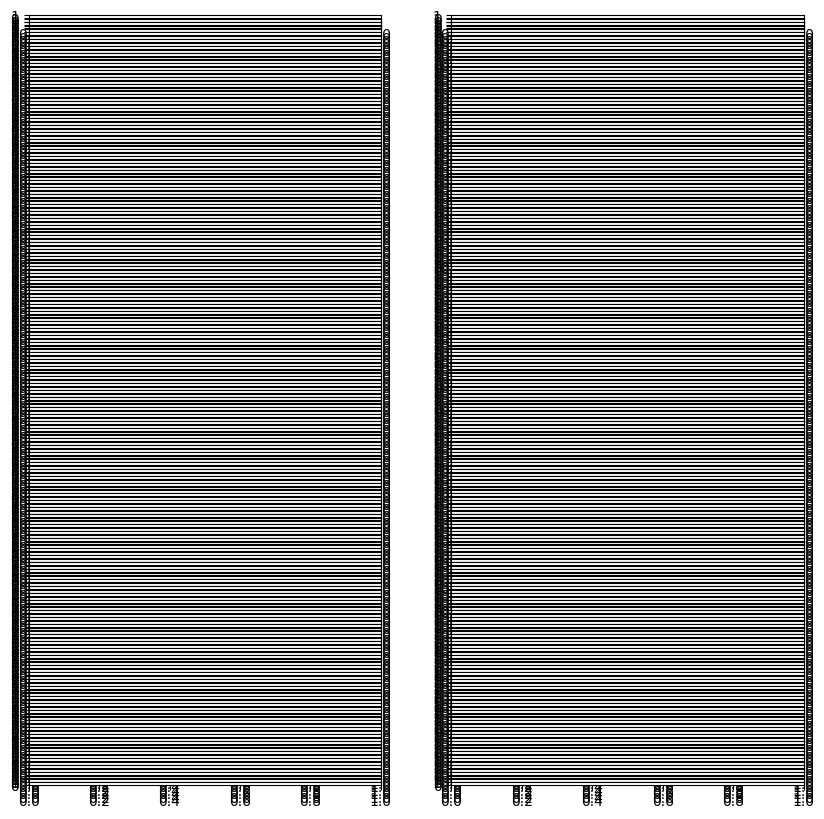

In [50]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_images(image_batch, label_batch):
    # Convert torch tensors to numpy arrays
    images = image_batch.squeeze().cpu().numpy()
    labels = label_batch.squeeze().cpu().numpy()

    # Plot each image and its label
    num_images = images.shape[0]
    fig, axes = plt.subplots(num_images, 2, figsize=(10, 10))

    for i in range(num_images):
        axes[i, 0].imshow(images[i, 0, :, :], cmap='gray')
        axes[i, 0].axis('off')
        axes[i, 0].set_title('Image')

        axes[i, 1].imshow(labels[i, 0, 0, :, :], cmap='gray')
        axes[i, 1].axis('off')
        axes[i, 1].set_title('Label')

    plt.tight_layout()
    plt.show()

# Visualize a batch of images from the train loader
for batch in train_loader:
    image_batch, label_batch = batch["image"], batch["label"]
    visualize_images(image_batch, label_batch)
    break  # Only visualize the first batch

# Visualize a batch of images from the validation loader
for batch in val_loader:
    image_batch, label_batch = batch["image"], batch["label"]
    visualize_images(image_batch, label_batch)
    break  # Only visualize the first batch


In [29]:
from monai.networks.nets import UNet
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.transforms import AsDiscrete, Activations, Compose
from monai.inferers import sliding_window_inference

max_epochs = 30
val_interval = 1
VAL_AMP = True

# standard PyTorch program style: create UNet, DiceLoss, and Adam optimizer
device = torch.device("cuda:0")
model = UNet(
    dimensions=3,
    in_channels=1, 
    out_channels=3,  
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)

loss_function = DiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, to_onehot_y=False, sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4, weight_decay=1e-5)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

dice_metric = DiceMetric(include_background=True, reduction="mean")
dice_metric_batch = DiceMetric(include_background=True, reduction="mean_batch")

post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])


# define inference method
def inference(input):
    def _compute(input):
        return sliding_window_inference(
            inputs=input,
            roi_size=(240, 240, 160),
            sw_batch_size=1,
            predictor=model,
            overlap=0.5,
        )

    if VAL_AMP:
        with torch.cuda.amp.autocast():
            return _compute(input)
    else:
        return _compute(input)


# use amp to accelerate training
scaler = torch.cuda.amp.GradScaler()
# enable cuDNN benchmark
torch.backends.cudnn.benchmark = True


/usr/local/lib/python3.8/dist-packages/monai/utils/deprecate_utils.py:219: FutureWarning: monai.networks.nets.unet UNet.__init__:dimensions: Argument `dimensions` has been deprecated since version 0.6. Please use `spatial_dims` instead.
  warn_deprecated(argname, msg, warning_category)


In [38]:
best_metric = -1
best_metric_epoch = -1
best_metrics_epochs_and_time = [[], [], []]
epoch_loss_values = []
metric_values = []
num_classes = 3
total_start = time.time()

# Training
for epoch in range(max_epochs):
    epoch_start = time.time()
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step_start = time.time()
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}"
            f", train_loss: {loss.item():.4f}"
            f", step time: {(time.time() - step_start):.4f}"
        )
    lr_scheduler.step()
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")


----------
epoch 1/30
1/225, train_loss: 0.6939, step time: 0.1415
2/225, train_loss: 0.6941, step time: 0.1076
3/225, train_loss: 0.6934, step time: 0.0993
4/225, train_loss: 0.6937, step time: 0.0991
5/225, train_loss: 0.6925, step time: 0.0962
6/225, train_loss: 0.6928, step time: 0.1450
7/225, train_loss: 0.6915, step time: 0.1008
8/225, train_loss: 0.6935, step time: 0.0968
9/225, train_loss: 0.6919, step time: 0.0979
10/225, train_loss: 0.6917, step time: 0.1389
11/225, train_loss: 0.6928, step time: 0.1018
12/225, train_loss: 0.6931, step time: 0.1078
13/225, train_loss: 0.6909, step time: 0.0975
14/225, train_loss: 0.6911, step time: 0.1391
15/225, train_loss: 0.6894, step time: 0.1294
16/225, train_loss: 0.6894, step time: 0.0992
17/225, train_loss: 0.6915, step time: 0.1005
18/225, train_loss: 0.6907, step time: 0.0934
19/225, train_loss: 0.6908, step time: 0.0930
20/225, train_loss: 0.6917, step time: 0.0988
epoch 1 average loss: 0.6920
----------
epoch 2/30
1/225, train_los

In [40]:
best_metric = -1
best_metric_epoch = -1
best_metrics_epochs_and_time = [[], [], []]
epoch_loss_values = []
metric_values = []
num_classes = 3
total_start = time.time()

# Training
for epoch in range(max_epochs):
    epoch_start = time.time()
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step_start = time.time()
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}"
            f", train_loss: {loss.item():.4f}"
            f", step time: {(time.time() - step_start):.4f}"
        )
    lr_scheduler.step()
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    # Calculate Mean Dice Score
    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            dice_scores = []
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                val_outputs = inference(val_inputs)
                print(val_inputs)
                print(val_inputs.shape)
                print(val_outputs)
                print(val_outputs.shape)
                val_outputs = torch.cat(val_outputs, dim=1)  # Concatenate the output channels
                val_labels_c = (val_labels.unsqueeze(1) == torch.arange(num_classes).unsqueeze(0).unsqueeze(-1).unsqueeze(-1).to(device)).float()
                val_outputs_c = val_outputs.permute(0, 2, 3, 4, 1)  # Reshape to match labels

                for c in range(num_classes):
                    val_labels_c_c = val_labels_c[:, c, ...]
                    val_outputs_c_c = val_outputs_c[:, :, :, :, c].unsqueeze(1)
                    dice_metric(y_pred=val_outputs_c_c, y=val_labels_c_c)
                    metric_c = dice_metric.aggregate().item()
                    print(f"Class {c} - Dice Score: {metric_c:.4f}")
                    dice_metric.reset()
                    dice_scores.append(metric_c)

            metric = dice_metric_batch.aggregate().item()
            metric_values.append(metric)
            dice_metric_batch.reset()

            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                best_metrics_epochs_and_time[0].append(best_metric)
                best_metrics_epochs_and_time[1].append(best_metric_epoch)
                best_metrics_epochs_and_time[2].append(time.time() - total_start)
                torch.save(
                    model.state_dict(),
                    os.path.join(root_dir, "best_metric_model.pth"),
                )
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
            
            # Print Mean Dice Scores
            mean_dice_scores = []
            for c in range(num_classes):
                mean_dice = np.mean([dice_scores[i] for i in range(c, len(dice_scores), num_classes)])
                mean_dice_scores.append(mean_dice)
                print(f"Mean Dice Score for Class {c}: {mean_dice:.4f}")
            print(f"Mean Dice Scores: {mean_dice_scores}")

    print(f"time consuming of epoch {epoch + 1} is: {(time.time() - epoch_start):.4f}")
total_time = time.time() - total_start


----------
epoch 1/30
1/225, train_loss: 0.6743, step time: 0.1459
2/225, train_loss: 0.6757, step time: 0.1050
3/225, train_loss: 0.6751, step time: 0.1126
4/225, train_loss: 0.6691, step time: 0.0955
5/225, train_loss: 0.6699, step time: 0.0994
6/225, train_loss: 0.6759, step time: 0.0934
7/225, train_loss: 0.6710, step time: 0.1012
8/225, train_loss: 0.6689, step time: 0.0955
9/225, train_loss: 0.6694, step time: 0.1356
10/225, train_loss: 0.6772, step time: 0.1366
11/225, train_loss: 0.6701, step time: 0.1071
12/225, train_loss: 0.6629, step time: 0.1062
13/225, train_loss: 0.6730, step time: 0.1406
14/225, train_loss: 0.6706, step time: 0.1079
15/225, train_loss: 0.6623, step time: 0.0990
16/225, train_loss: 0.6753, step time: 0.0948
17/225, train_loss: 0.6691, step time: 0.0967
18/225, train_loss: 0.6739, step time: 0.1379
19/225, train_loss: 0.6730, step time: 0.1161
20/225, train_loss: 0.6714, step time: 0.0990
epoch 1 average loss: 0.6714
tensor([[[[[-1.0741, -1.0741, -1.0741,

TypeError: cat() received an invalid combination of arguments - got (MetaTensor, dim=int), but expected one of:
 * (tuple of Tensors tensors, int dim, *, Tensor out)
 * (tuple of Tensors tensors, name dim, *, Tensor out)
